# DTSA-5511 Final Project

For this project, I decided I wanted to use this as an opportunity to learn about bioinformatics and pharmacology. I started by searching for a topic and dataset to base the project on, and I came across the Genomics of Drug Sensitivity in Cancer ([GDSC](https://www.cancerrxgene.org/)) data repository. GDSC has collected data on hundreds of different drugs with measurements of their efficacy in inhibiting the growth of cancer cells (the GDSC data contains drug inihibition measurements for approximately 1000 cancer cell lines).

Looking through the GDSC website, I soon realized that it would be too difficult for a non-expert like me to assemble a dataset for this project from "scratch". Fortunately, I found the [PyTDC](https://pypi.org/project/pytdc/) project (from the [Therapeutics Data Commons](https://tdcommons.ai/) group), which offers a packaged version of the GDSC raw data in a ready-to-use form for ML. Then all I had to do to access the GDSC data was to install the `PyTDC` library and import the dataframe into Pandas.

With the GDSC data in hand, as I started doing some EDA and transformations, I quickly found that my local machine, even with 32 GB of RAM, was not going to be up to the task of manipulating dataframes on the order of ~175,000 rows and ~20,000 columns. I thought about condensing the dataset into a randomly sampled subset, but I was concerned that this would hinder model performance. In the end, I decided to use a Google Colab environment with 171 GB RAM and an NVIDIA A100 GPU. This came with its own set of difficulties, but utimately Colab was able to support the compute needs for the project. This turned out to be a good lesson in the pitfalls of managing a "large" dataset.

### **Spoiler!**
The final results from the models are not very strong. I need to consult with domain experts and do more research to understand how to improve these.

## Project Goal and Background Info

The goal of this project is to build a deep learning model that predicts a drug's efficacy at inhibiting the growth of cancer cells. We'll start by describing the data in the GDSC dataset to understand how the model can make its predictions.

The dataset is structured around drug/cell line pairings. Each row represents an experiment where a specific drug was tested on a particular cancer cell line*.

### Model Input
The model will use two main types of input data to make its predictions.

1) **Cell Line:** A large portion of each row in the dataset is dedicated to a cancer cell's **gene expression profile**. This profile is represented by approximately 17,000 columns, where each column corresponds to a specific gene. The value in each of these columns quantifies that gene's activity level—indicating whether it is more or less active ("turned on" or "off") in that particular cancer cell. Together, these columns provide a detailed molecular snapshot of the cancer cell for the model to learn from.

2) **Drug:** For each row in the data, there is also sizeable number of columns dedicated to the **drug's molecular structure**. The molecular structure is first encoded in what is called a [SMILES (Simplified Molecular-Input Line-Entry System)](https://en.wikipedia.org/wiki/Simplified_Molecular_Input_Line_Entry_System) string. For inputing the drug's molecular data into the neural network, we convert the SMILES string into numerical form using a method called a [Morgan Fingerprint](https://darkomedin-datascience.medium.com/data-science-for-drug-discovery-research-morgan-fingerprints-using-alanine-and-testosterone-92a2c69dd765). This process transforms the chemical structure of each drug into a fixed-length vector of 0s and 1s (2048 bits long). Each position in the vector represents the presence or absence of specific chemical components. These 2048 fingerprint values become columns in the dataset, providing the model with a detailed numerical profile of the drug's chemical features.

### Model Output

The model's target variable is the log of the measured **IC50 value** for each row's drug/cell line pairing. [IC50](https://en.wikipedia.org/wiki/IC50) is a standard measure of a drug's potency. It represents the concentration of a drug required to inhibit a biological process (such as cancer cell growth) by 50%. To determine this value, cell samples are exposed in a laboratory to varying concentrations of the drug. After an incubation period, [cell viability](https://en.wikipedia.org/wiki/Viability_assay) is measured (often by measuring light intensity shone through the samples, which correlates with the number of living cells). A dose-response curve, typically a [4-parameter logistic curve](https://www.quantics.co.uk/blog/what-is-the-4pl-formula/), is then fitted to these measurements to calculate the IC50 value.

Therefore, the objective is to train a model that can take a cell line's gene expression profile and a drug's chemical structure as input and accurately predict the resulting IC50 value. This is a regression task in the output of the neural network.

*A cell line is a population of cancer cells that have been sampled from a patient and re-grown in a laboratory. Different cell lines can represent one type of cancer (for example, breast cancer), yet each cell line is genetically unique as it originates from one particular patient.

## Data Preparation and EDA

In [ ]:
!pip install PyTDC

In [ ]:
!pip install rdkit

In [5]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns

from rdkit import Chem
from rdkit.Chem import AllChem

from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import GroupShuffleSplit

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from tdc.multi_pred import DrugRes

### First look at the data

We'll use the [DrugRes](https://tdcommons.ai/multi_pred_tasks/drugres/) object to create a Pandas dataframe containing the GDSC data.

The dataframe initially has 5 columns:

`Drug_ID`: Commerical drug name.  
`Drug`: Column containing the SMILES string that encodes the molecular structure for the drug.  
`Cell Line_ID`: GDSC [cell line ID](https://www.cancerrxgene.org/celllines).  
`Cell Line`: Column where each row stores an array of 17737 gene expressions for the cancer cell line.  
`Y`: Measured IC50 value for the drug/cell line pair.  

From the first 5 rows, we can see that one drug is paired with multiple cell lines, with a different IC50 measurement for each.

In [6]:
# Load the GDSC dataset from TDC
data = DrugRes(name = 'gdsc1')

# Get the entire dataset as a pandas dataframe
gdsc1_df = data.get_data()

gdsc1_df.head()

Found local copy...
Loading...
Done!


,Drug_ID,Drug,Cell Line_ID,Cell Line,Y
0,Erlotinib,COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...,MC-CAR,"[3.23827250519154, 2.98225419469807, 10.235490...",2.395685
1,Erlotinib,COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...,ES3,"[8.690197905033282, 3.0914731119366, 9.9924871...",3.140923
2,Erlotinib,COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...,ES5,"[8.233101127037282, 2.82468731112752, 10.01588...",3.968757
3,Erlotinib,COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...,ES7,"[8.33346622426757, 3.9667571228514302, 9.79399...",2.692768
4,Erlotinib,COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...,EW-11,"[8.39134072442845, 2.9683601858810698, 10.2606...",2.478678


### Gene Labels Transformation

Rather than having a single 17737-long gene expression array in each row, it would be better for analysis to put each gene in its own labeled column. To do this, first we need to get the gene labels.

In [7]:
# Get the gene symbols
gene_labels = data.get_gene_symbols()
print(f"Total number of genes: {len(gene_labels)}")
print(f"\nFirst 20 gene symbols:")
print(gene_labels[:20])

Found local copy...
Loading...


Total number of genes: 17737

First 20 gene symbols:
['TSPAN6' 'TNMD' 'DPM1' 'SCYL3' 'C1orf112' 'FGR' 'CFH' 'FUCA2' 'GCLC'
 'NFYA' 'STPG1' 'NIPAL3' 'LAS1L' 'ENPP4' 'SEMA3F' 'CFTR' 'ANKIB1' 'KRIT1'
 'RAD52' 'BAD']


In [8]:
type(gene_labels)

numpy.ndarray

Unpack the long `Cell Line` arrays and stack them so that the elements fall into labeled columns. This creates `gene_expression_df` with 177310 rows and 17737 columns.

In [10]:
gene_expression_df = pd.DataFrame(
    np.stack(gdsc1_df['Cell Line'].values),
    columns=gene_labels,
    dtype=np.float32
)

In [11]:
gene_expression_df.head()

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,LINC00526,PPY2,NaN,NaN,KRT18P55,NaN,POLRMTP1,UBL5P2,TBC1D3P5,NaN
0,3.238272,2.982254,10.235491,4.856061,4.078870,9.116236,3.658590,6.145475,5.042464,5.438402,...,5.866047,3.095716,3.502513,8.564318,3.274367,4.018073,3.056214,9.446305,3.530871,6.134269
1,8.690198,3.091473,9.992487,4.572198,3.333385,3.320793,3.159487,3.515105,5.446361,5.348338,...,5.097089,3.114744,3.120520,8.591651,3.119647,2.588673,3.194925,9.013220,3.074187,8.173054
2,8.233101,2.824687,10.015883,4.749715,3.839433,3.142755,5.329830,3.272124,5.538055,6.428482,...,6.261573,3.031862,3.370459,8.930821,3.322455,3.083922,2.813440,8.893197,3.266184,8.758288
3,8.333467,3.966757,9.793991,3.976923,3.505669,3.079943,3.373640,4.199048,5.794734,5.902391,...,3.885425,2.993918,2.843472,8.246666,3.219777,3.683564,3.033869,8.691401,3.279230,8.236238
4,8.391340,2.968360,10.260679,4.295876,4.129471,3.318760,7.103957,3.447994,5.988207,6.257495,...,5.584552,2.959515,2.952987,8.625519,3.056066,3.059551,3.127004,9.396461,3.217885,7.248236


In [13]:
gene_expression_df.shape

(177310, 17737)

Reattach the `gene_expression_df` with the `Drug_ID`, `Drug`, and `Cell Line_ID` columns.

In [14]:
# Extract non-genomics columns from the original gdsc1_df dataframe
gdsc1_meta_df = gdsc1_df[['Drug_ID', 'Drug', 'Cell Line_ID', 'Y']]

# Concatenate with the new gene_expression_df
gdsc1_processed_df = pd.concat([gdsc1_meta_df, gene_expression_df], axis=1)

print(f"Shape of the gdsc1_processed_df dataframe: {gdsc1_processed_df.shape}")
gdsc1_processed_df.head()

Shape of the gdsc1_processed_df dataframe: (177310, 17741)


,Drug_ID,Drug,Cell Line_ID,Y,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,...,LINC00526,PPY2,NaN,NaN,KRT18P55,NaN,POLRMTP1,UBL5P2,TBC1D3P5,NaN
0,Erlotinib,COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...,MC-CAR,2.395685,3.238272,2.982254,10.235491,4.856061,4.078870,9.116236,...,5.866047,3.095716,3.502513,8.564318,3.274367,4.018073,3.056214,9.446305,3.530871,6.134269
1,Erlotinib,COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...,ES3,3.140923,8.690198,3.091473,9.992487,4.572198,3.333385,3.320793,...,5.097089,3.114744,3.120520,8.591651,3.119647,2.588673,3.194925,9.013220,3.074187,8.173054
2,Erlotinib,COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...,ES5,3.968757,8.233101,2.824687,10.015883,4.749715,3.839433,3.142755,...,6.261573,3.031862,3.370459,8.930821,3.322455,3.083922,2.813440,8.893197,3.266184,8.758288
3,Erlotinib,COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...,ES7,2.692768,8.333467,3.966757,9.793991,3.976923,3.505669,3.079943,...,3.885425,2.993918,2.843472,8.246666,3.219777,3.683564,3.033869,8.691401,3.279230,8.236238
4,Erlotinib,COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...,EW-11,2.478678,8.391340,2.968360,10.260679,4.295876,4.129471,3.318760,...,5.584552,2.959515,2.952987,8.625519,3.056066,3.059551,3.127004,9.396461,3.217885,7.248236


### Check for missing values

No null or missing values in the dataframe.

In [15]:
gdsc1_processed_df.isnull().sum().sum()

0

### IC50 Analysis

The summary statistics for the `Y` column show a fairly wide range of values. We see negative numbers because the values are not the drug concentration itself, but rather the natural log of the concentration of the drug in µM.

These values represent how effective a drug is at inhibiting cancer cell growth. The fact that the mean is less than the median (the 50th percentile) indicates that the distribution of IC50 values is skewed to the left. This means there is a tail of potent drug-cell interactions (very low IC50 values) that pull the overall average down.

In [16]:
gdsc1_processed_df['Y'].describe()

,Y
count,177310.000000
mean,2.007088
std,2.714737
min,-9.933406
25%,0.587560
50%,2.459601
75%,3.908216
max,12.359056


In the plot, the slight skew to the left confirms the prevalence of lower IC50 values. Despite the skew, the plot qualitatively looks "normal" enough with no obvious outliers, so we can proceed with this for regression modeling.

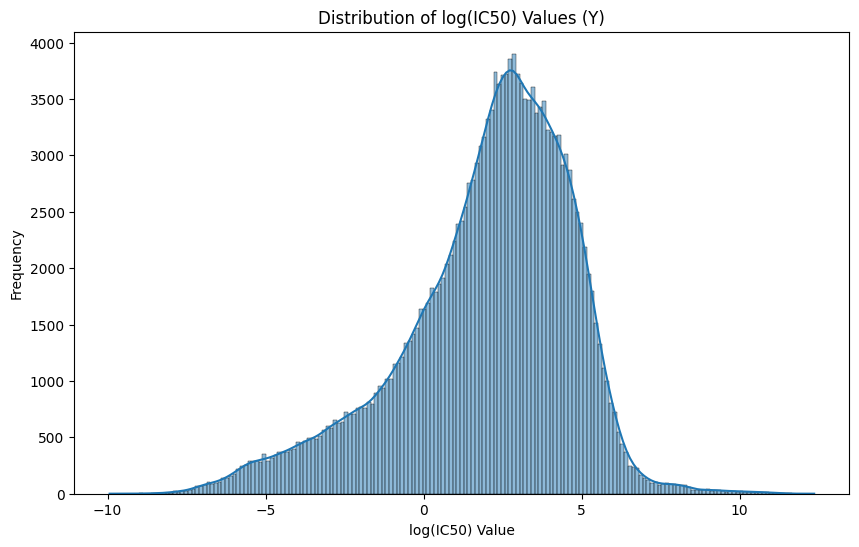

In [17]:
# Histogram of the 'Y' variable
plt.figure(figsize=(10, 6))
sns.histplot(gdsc1_processed_df['Y'], kde=True)
plt.title('Distribution of log(IC50) Values (Y)')
plt.xlabel('log(IC50) Value')
plt.ylabel('Frequency')
plt.show()

### Drug Analysis

The dataset contains **208 unique drugs**. The frequency of each drug varies widely; the most common drug is tested in **1,837** experiments, while the least common is tested in only **372**. This imbalance is visible in the distribution plot, where a few drugs account for a large portion of the data.

In [18]:
gdsc1_processed_df['Drug_ID'].nunique()

208

In [19]:
gdsc1_processed_df['Drug_ID'].value_counts().max()

1837

In [20]:
gdsc1_processed_df['Drug_ID'].value_counts().min()

372

In [21]:
gdsc1_processed_df['Drug_ID'].value_counts().head(20)

,count
Drug_ID,
PLX-4720,1837
Afatinib,1824
Avagacestat,1823
Olaparib,1819
UNC0638,1803
Pictilisib,1786
Selumetinib,1781
Refametinib,1772
AZD6482,1762


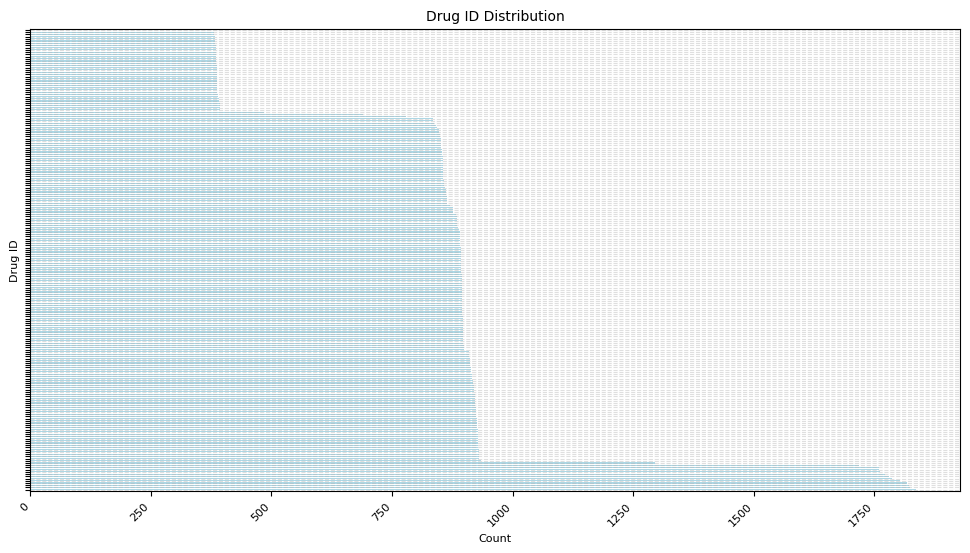

In [22]:
drug_ID_counts = gdsc1_processed_df['Drug_ID'].value_counts()

plt.figure(figsize=(12, 6))
drug_ID_counts.plot(kind="barh", color='lightblue')
plt.xlabel("Count", fontsize=8)
plt.ylabel("Drug ID", fontsize=8)
plt.title("Drug ID Distribution", fontsize=10)
plt.xticks(rotation=45, ha="right", fontsize=8)
plt.tick_params(axis='y', labelleft=False) # Hide y-axis labels
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.show()

### Cell Line Analysis

There are **958 unique cell lines** in the dataset. Similar to the drugs, the cell lines are also imbalanced. The most frequently used cell line appears in **221** experiments, whereas the least common appears in just **1** experiment. Looking at the distribution plot, overall this imbalance is less pronounced than with the drugs but still notable.

In [23]:
gdsc1_processed_df['Cell Line_ID'].nunique()

958

In [24]:
gdsc1_processed_df['Cell Line_ID'].value_counts().max()

221

In [25]:
gdsc1_processed_df['Cell Line_ID'].value_counts().min()

1

In [26]:
gdsc1_processed_df['Cell Line_ID'].value_counts().head(50)

,count
Cell Line_ID,
TE-12,221
EW-1,221
LAN-6,221
EW-16,221
SNB75,221
NCI-H1436,221
NCI-H1155,221
OS-RC-2,221
COLO-684,221


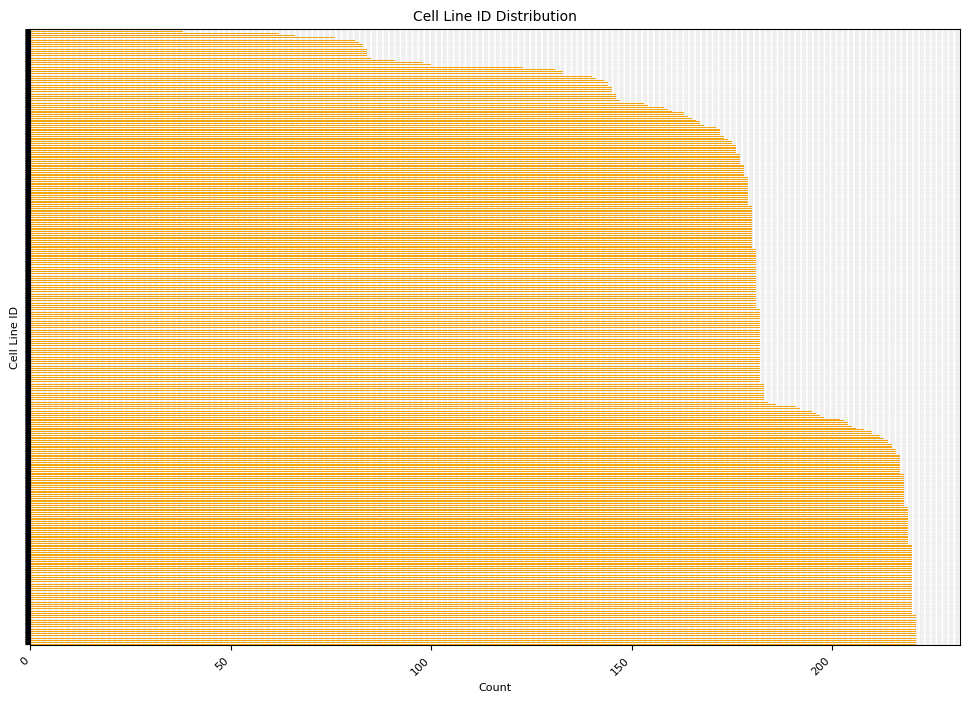

In [27]:
cell_line_counts = gdsc1_processed_df['Cell Line_ID'].value_counts()

plt.figure(figsize=(12, 8))
cell_line_counts.plot(kind="barh", color='orange')
plt.xlabel("Count", fontsize=8)
plt.ylabel("Cell Line ID", fontsize=8)
plt.title("Cell Line ID Distribution", fontsize=10)
plt.xticks(rotation=45, ha="right", fontsize=8)
plt.tick_params(axis='y', labelleft=False) # Hide y-axis labels
plt.grid(axis="y", linestyle="--", alpha=0.1)
plt.show()

### Gene Expression Analysis

The initial dataset contains 17,737 gene expression features. To begin analyzing them, we calculate the variance of each gene across all experiments. The plot below visualizes this variance, sorted from lowest to highest. It shows that a large majority of genes have a variance at or near zero, meaning their expression levels do not change much across different cell lines.

In [28]:
# Calculate the variance of each gene expression column
gene_expression_variance = gene_expression_df.var()

print("Variance of gene expression for first five genes:")
print(gene_expression_variance.head())

# Sort the variances to see which genes have the highest/lowest variance
print("\nTop 10 genes with highest variance:")
print(gene_expression_variance.sort_values(ascending=False).head(10))

print("\nTop 10 genes with lowest variance:")
print(gene_expression_variance.sort_values(ascending=True).head(10))

Variance of gene expression for first five genes:
TSPAN6      3.662867
TNMD        0.044250
DPM1        0.303579
SCYL3       0.281605
C1orf112    0.179087
dtype: float32

Top 10 genes with highest variance:
RPS4Y1     15.797991
KRT19      15.387221
VIM        13.534711
S100P      13.134761
TACSTD2    12.856094
TGFBI      12.287282
NaN        12.262770
TM4SF1     12.058323
CAV1       11.791290
SRGN       11.769511
dtype: float32

Top 10 genes with lowest variance:
ECT2L      0.006489
GLRA3      0.006848
PCDH15     0.007026
ANKUB1     0.007276
C4orf40    0.007569
DEFB121    0.007648
C2orf73    0.007759
NME9       0.007880
MOBP       0.007926
OPRM1      0.008042
dtype: float32


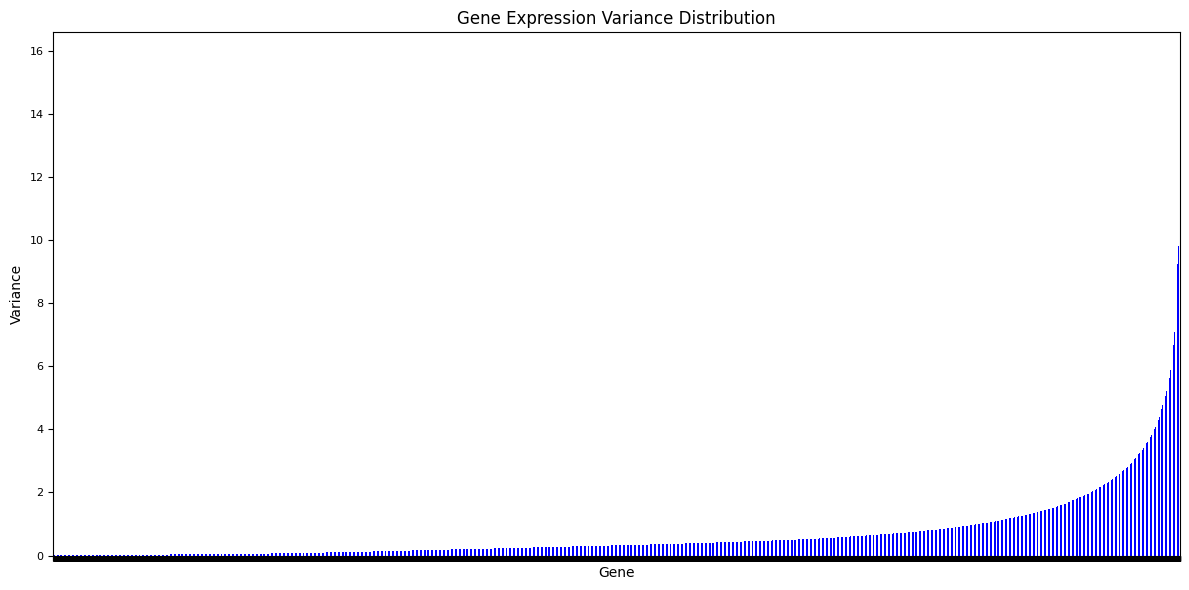

In [29]:
plt.figure(figsize=(12, 6))
gene_expression_variance.sort_values().plot(kind="bar", color='blue')
plt.xlabel("Gene", fontsize=10)
plt.ylabel("Variance", fontsize=10)
plt.title("Gene Expression Variance Distribution", fontsize=12)
plt.tick_params(axis='x', labelbottom=False) # Hide x-axis labels (gene names)
plt.tick_params(axis='y', labelsize=8)
plt.tight_layout()
plt.show()

Many of these genes show little variance across the cell lines, which means that their predictive power is limited. We can do dimensionality reduction by removing a portion of the low-variance genes. To reduce dimensionality, we apply a variance threshold of 0.1 using the [VarianceThreshold](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html) method from scikit-learn. This filtering step retains 13,391 of the genes for modeling.

In [30]:
# Define a variance threshold
threshold = 0.1

selector = VarianceThreshold(threshold=threshold)

# Convert column names to strings
gene_expression_df.columns = gene_expression_df.columns.astype(str)

# Fit and transform the gene expression data
gene_expression_thresholded = selector.fit_transform(gene_expression_df)

# Get the names of the selected genes
selected_genes = gene_expression_df.columns[selector.get_support()]

# Create a new dataframe with the selected genes
gene_expression_df_filtered = pd.DataFrame(gene_expression_thresholded, columns=selected_genes, index=gene_expression_df.index)

print(f"Original number of genes: {gene_expression_df.shape[1]}")
print(f"Number of genes after variance thresholding (threshold={threshold}): {gene_expression_df_filtered.shape[1]}")

gene_expression_df_filtered.head()

Original number of genes: 17737
Number of genes after variance thresholding (threshold=0.1): 13391


,TSPAN6,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,STPG1,...,OR1D5,ZNF234,nan,MYH4,LINC00526,nan,nan,nan,UBL5P2,nan
0,3.238272,10.235491,4.856061,4.078870,9.116236,3.658590,6.145475,5.042464,5.438402,3.336360,...,3.724013,3.981948,3.904874,2.823245,5.866047,3.502513,8.564318,4.018073,9.446305,6.134269
1,8.690198,9.992487,4.572198,3.333385,3.320793,3.159487,3.515105,5.446361,5.348338,3.291030,...,2.929492,4.702209,4.186925,2.489674,5.097089,3.120520,8.591651,2.588673,9.013220,8.173054
2,8.233101,10.015883,4.749715,3.839433,3.142755,5.329830,3.272124,5.538055,6.428482,2.980635,...,3.226083,4.666296,5.399840,2.491254,6.261573,3.370459,8.930821,3.083922,8.893197,8.758288
3,8.333467,9.793991,3.976923,3.505669,3.079943,3.373640,4.199048,5.794734,5.902391,3.301069,...,3.738082,4.705392,3.594570,2.667881,3.885425,2.843472,8.246666,3.683564,8.691401,8.236238
4,8.391340,10.260679,4.295876,4.129471,3.318760,7.103957,3.447994,5.988207,6.257495,3.607291,...,3.522861,4.500115,3.958256,2.600511,5.584552,2.952987,8.625519,3.059551,9.396461,7.248236


### Drug Transformation

In [31]:
# Retrieve unique drug IDs and their SMILES strings
drug_smiles_df = gdsc1_processed_df[['Drug_ID', 'Drug']].drop_duplicates().reset_index(drop=True)

print(f"\nNumber of unique drugs: {drug_smiles_df.shape[0]}")

drug_smiles_df.head()


Number of unique drugs: 208


,Drug_ID,Drug
0,Erlotinib,COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...
1,Sunitinib,CCN(CC)CCNC(=O)C1=C(NC(=C1C)/C=C\2/C3=C(C=CC(=...
2,PHA-665752,CC1=C(NC(=C1C(=O)N2CCC[C@@H]2CN3CCCC3)C)/C=C\4...
3,MG-132,CC(C)C[C@@H](C=O)NC(=O)[C@H](CC(C)C)NC(=O)[C@H...
4,Paclitaxel,CC1=C2[C@H](C(=O)[C@@]3([C@H](C[C@@H]4[C@]([C@...


The `Drug` column in the `drug_smiles_df` dataframe contains the SMILES strings for each unique drug. The SMILES string is not a suitable format for direct input into a neural network, so we need to convert these into the numerical **Morgan Fingerprint** representation using the [AllChem](https://www.rdkit.org/docs/source/rdkit.Chem.AllChem.html) package. This "fingerprint" allows the model to learn relationships between a drug's chemical features and its efficacy.

In [32]:
# Function to generate chemical fingerprints
def generate_fingerprint(smiles, radius=2, nbits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        return np.array(AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nbits))
    return np.array([0] * nbits) # Return a zero vector for invalid SMILES

# Apply the function to the drug_smiles_df
fingerprint_matrix = np.vstack(drug_smiles_df['Drug'].apply(generate_fingerprint))

# Create a a new dataframe from the fingerprints_matrix
fingerprint_df = pd.DataFrame(fingerprint_matrix, columns=[f'FP_{i}' for i in range(fingerprint_matrix.shape[1])])

# Add the Drug_ID back to the fingerprint_df for merging
fingerprint_df['Drug_ID'] = drug_smiles_df['Drug_ID']

print(f"\nShape of the fingerprint DataFrame: {fingerprint_df.shape}")

fingerprint_df.head()


Shape of the fingerprint DataFrame: (208, 2049)


,FP_0,FP_1,FP_2,FP_3,FP_4,FP_5,FP_6,FP_7,FP_8,FP_9,...,FP_2039,FP_2040,FP_2041,FP_2042,FP_2043,FP_2044,FP_2045,FP_2046,FP_2047,Drug_ID
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Erlotinib
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,Sunitinib
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,PHA-665752
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,MG-132
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Paclitaxel


### Training and Test Set Preparation

With the gene expression and drug fingerprint features prepared, the next step is to combine them into a single, unified dataframe. We merge the filtered gene expression data with the drug fingerprints based on their respective indices and `Drug_ID`. This `gdsc1_merged_df` will serve as the complete dataset for training and evaluating our model.

In [33]:
# Merge gene_expression_df_filtered with fingerprint_df based on Drug_ID
gdsc1_merged_df = pd.merge(
    gdsc1_processed_df[['Drug_ID', 'Cell Line_ID', 'Y']], # Include metadata needed for split
    gene_expression_df_filtered,
    left_index=True,
    right_index=True
)

gdsc1_merged_df = pd.merge(
    gdsc1_merged_df,
    fingerprint_df,
    on='Drug_ID',
    how='left'
)

print(f"\nShape of the gdsc1_merged_df: {gdsc1_merged_df.shape}")

gdsc1_merged_df.head()


Shape of the gdsc1_merged_df: (177310, 15442)


,Drug_ID,Cell Line_ID,Y,TSPAN6,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,...,FP_2038,FP_2039,FP_2040,FP_2041,FP_2042,FP_2043,FP_2044,FP_2045,FP_2046,FP_2047
0,Erlotinib,MC-CAR,2.395685,3.238272,10.235491,4.856061,4.078870,9.116236,3.658590,6.145475,...,0,0,0,0,0,0,0,0,0,0
1,Erlotinib,ES3,3.140923,8.690198,9.992487,4.572198,3.333385,3.320793,3.159487,3.515105,...,0,0,0,0,0,0,0,0,0,0
2,Erlotinib,ES5,3.968757,8.233101,10.015883,4.749715,3.839433,3.142755,5.329830,3.272124,...,0,0,0,0,0,0,0,0,0,0
3,Erlotinib,ES7,2.692768,8.333467,9.793991,3.976923,3.505669,3.079943,3.373640,4.199048,...,0,0,0,0,0,0,0,0,0,0
4,Erlotinib,EW-11,2.478678,8.391340,10.260679,4.295876,4.129471,3.318760,7.103957,3.447994,...,0,0,0,0,0,0,0,0,0,0


To ensure that the model generalizes to new, unseen drugs, we must prevent data leakage between the training and test sets. A standard random split would be inappropriate here, as it could place data from the same drug into both sets. This would allow the model to "memorize" a drug's behavior rather than learn its properties.

To address this, we use `GroupShuffleSplit` from scikit-learn, with `Drug_ID` as the grouping variable. This method guarantees that all data for any given drug is confined to either the training set or the test set, but not both. By doing this, we can more reliably assess the model's ability to predict the efficacy of drugs it has never seen before. We allocate 80% of the drugs for training and reserve the remaining 20% for testing.

In [34]:
# Define the features (X) and the target (y)

# Define X from the merged dataframe, excluding metadata and target
X = gdsc1_merged_df.drop(columns=['Drug_ID', 'Cell Line_ID', 'Y'])
y = gdsc1_merged_df['Y']
groups = gdsc1_merged_df['Drug_ID']

# Initialize the GroupShuffleSplit for train/test split
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# The .split() method returns the indices for the train and test sets
train_idx, test_idx = next(gss.split(X, y, groups))

# Create the train and test sets using the indices
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

train_drugs = set(gdsc1_merged_df.iloc[train_idx]['Drug_ID'])
test_drugs = set(gdsc1_merged_df.iloc[test_idx]['Drug_ID'])
common_drugs = train_drugs.intersection(test_drugs)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"\nNumber of drugs in training set: {len(train_drugs)}")
print(f"Number of drugs in testing set: {len(test_drugs)}")
print(f"Number of drugs common to both sets: {len(common_drugs)}")

X_train shape: (138279, 15439)
y_train shape: (138279,)
X_test shape: (39031, 15439)
y_test shape: (39031,)

Number of drugs in training set: 166
Number of drugs in testing set: 42
Number of drugs common to both sets: 0


Finally, we separate the features into their respective inputs for the multi-input neural network. The gene expression data (`X_train_genes`, `X_test_genes`) and the drug fingerprint data (`X_train_fp`, `X_test_fp`) are prepared as two distinct numpy arrays. This structure will allow our model to process each type of information through its own specialized branch before merging them for the final prediction.

In [44]:
# Select the gene expression data for train and test sets directly from the filtered dataframe
X_train_genes = gene_expression_df_filtered.iloc[train_idx].values
X_test_genes = gene_expression_df_filtered.iloc[test_idx].values

# Select the fingerprint data for train and test sets
X_train_fp = X_train[fp_cols].values
X_test_fp = X_test[fp_cols].values

print(f"X_train_genes shape: {X_train_genes.shape}")
print(f"X_train_fp shape: {X_train_fp.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"\nX_test_genes shape: {X_test_genes.shape}")
print(f"X_test_fp shape: {X_test_fp.shape}")
print(f"y_test shape: {y_test.shape}")

X_train_genes shape: (138279, 13391)
X_train_fp shape: (138279, 2048)
y_train shape: (138279,)

X_test_genes shape: (39031, 13391)
X_test_fp shape: (39031, 2048)
y_test shape: (39031,)


In [47]:
print("\nFirst 5 rows of X_train_genes:")
print(X_train_genes[:5])


First 5 rows of X_train_genes:
[[ 3.2382724 10.235491   4.8560615 ...  4.018073   9.446305   6.134269 ]
 [ 8.690198   9.992487   4.572198  ...  2.588673   9.01322    8.173054 ]
 [ 8.233101  10.015883   4.749715  ...  3.0839217  8.893197   8.758288 ]
 [ 8.333467   9.793991   3.9769228 ...  3.6835642  8.691401   8.2362385]
 [ 8.39134   10.260679   4.2958755 ...  3.0595508  9.3964615  7.248236 ]]


## Model Training

### Model 1

Our first model is a multi-input neural network to process the two types of features simultaneously (gene expression and drug fingerprint data).

**Input Branches**:  
The model has two separate input branches:  
1) **Gene Expression Branch**: This branch processes the 13,391 gene expression features. It consists of two dense layers (`Dense`) with ReLU activation, between which is a dropout layer (`Dropout`) to prevent overfitting.  
2) **Drug Fingerprint Branch**: This branch handles the 2048 drug fingerprint features, also using a sequence of dense and dropout layers.

**Merging**: The outputs from the two branches are then concatenated into a single vector.

**Fully Connected Layers**: This merged vector is passed through two more dense layers, with dropout applied after the first, to allow the model to learn from the combined features.

**Output Layer**: The final layer is a single densely-connected neuron with a linear activation function, which outputs the predicted log(IC50) value, making it a regression model.

The model is compiled using the Adam optimizer and the mean squared error (MSE) loss function, which is appropriate for this regression task.

In [48]:
# Model 1

# Gene Expression Branch
gene_input = Input(shape=(X_train_genes.shape[1],), name='gene_input')
gene_branch = Dense(256, activation='relu')(gene_input)
gene_branch = Dropout(0.3)(gene_branch)
gene_branch = Dense(128, activation='relu')(gene_branch)

# Drug Fingerprint Branch
fp_input = Input(shape=(X_train_fp.shape[1],), name='fp_input')
fp_branch = Dense(128, activation='relu')(fp_input)
fp_branch = Dropout(0.3)(fp_branch)
fp_branch = Dense(64, activation='relu')(fp_branch)

# Merge Branches
merged = Concatenate()([gene_branch, fp_branch])
merged = Dense(256, activation='relu')(merged)
merged = Dropout(0.4)(merged)
merged = Dense(128, activation='relu')(merged)

# Output Layer
output = Dense(1, activation='linear', name='output')(merged) # Linear activation for regression

model = Model(inputs=[gene_input, fp_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ gene_input          │ (None, 13391)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fp_input            │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │  3,428,352 │ gene_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │    262,272 │ fp_input[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      8,256 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 192)       │          0 │ dense_1[0][0],    │
│ (Concatenate)       │                   │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │     49,408 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 128)       │     32,896 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │        129 │ dense_5[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,814,209 (14.55 MB)

 Trainable params: 3,814,209 (14.55 MB)

 Non-trainable params: 0 (0.00 B)

In [49]:
history = model.fit(
    [X_train_genes, X_train_fp],
    y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=128,
    verbose=1
)

Epoch 1/50
865/865 ━━━━━━━━━━━━━━━━━━━━ 25s 21ms/step - loss: 40.4876 - val_loss: 7.4204
Epoch 2/50
865/865 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 2.2950 - val_loss: 7.4493
Epoch 3/50
865/865 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 2.2198 - val_loss: 7.3641
Epoch 4/50
865/865 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 2.1992 - val_loss: 7.2503
Epoch 5/50
865/865 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 2.1641 - val_loss: 7.1235
Epoch 6/50
865/865 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 2.1610 - val_loss: 7.1794
Epoch 7/50
865/865 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 2.1625 - val_loss: 7.2887
Epoch 8/50
865/865 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 2.1400 - val_loss: 7.0878
Epoch 9/50
865/865 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 2.1521 - val_loss: 7.3711
Epoch 10/50
865/865 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 2.1544 - val_loss: 7.3339
Epoch 11/50
865/865 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 2.1258 - val_loss: 7.2558
Epoch 12/50
865/865 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/s

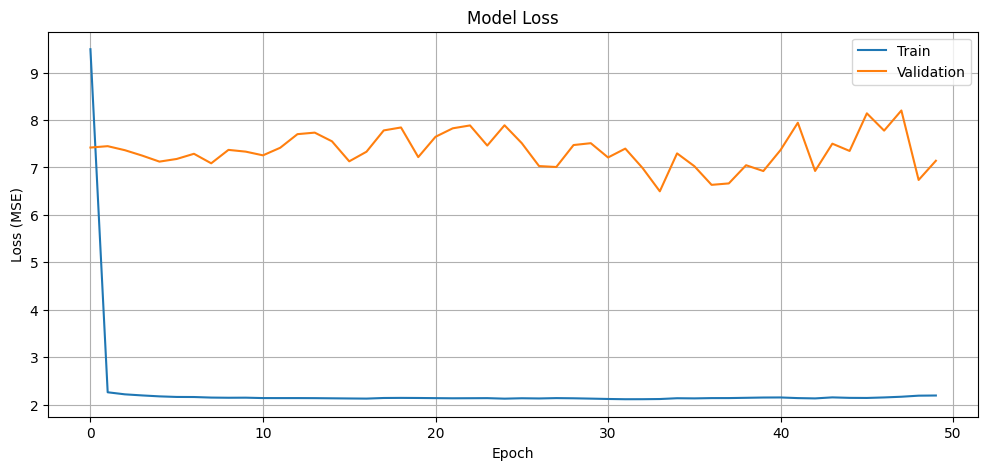

Test Set Mean Squared Error: 4.6692
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


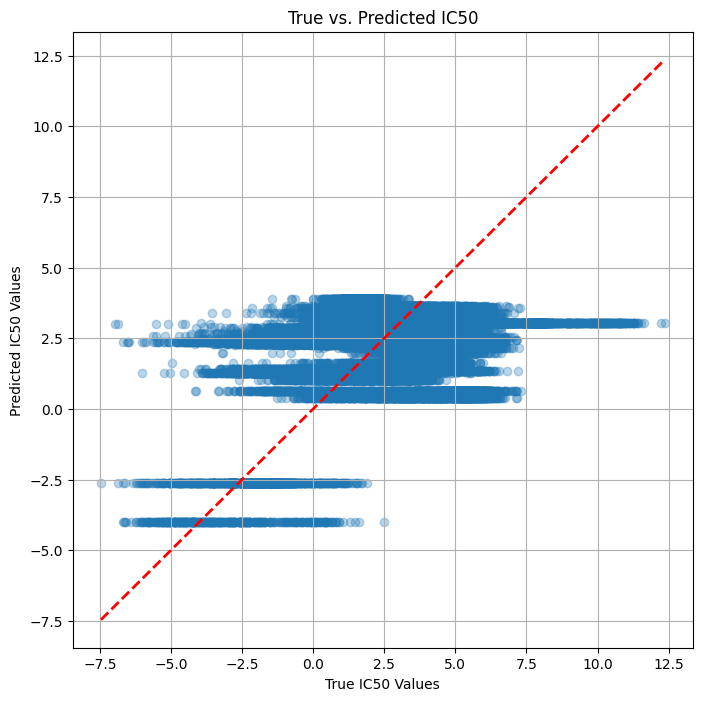

In [50]:
# Plot training & validation loss values
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.grid(True)
plt.show()

# Evaluate the model on the test set
test_loss = model.evaluate([X_test_genes, X_test_fp], y_test, verbose=0)
print(f"Test Set Mean Squared Error: {test_loss:.4f}")

# Make predictions on the test set
y_pred = model.predict([X_test_genes, X_test_fp]).flatten()

# Plot true vs. predicted values
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('True IC50 Values')
plt.ylabel('Predicted IC50 Values')
plt.title('True vs. Predicted IC50')
plt.grid(True)
plt.show()

In [51]:
# Model 2

# Gene Expression Branch
gene_input_v2 = Input(shape=(X_train_genes.shape[1],), name='gene_input_v2')
gene_branch_v2 = Dense(128, activation='relu')(gene_input_v2)
gene_branch_v2 = Dropout(0.5)(gene_branch_v2)
gene_branch_v2 = Dense(64, activation='relu')(gene_branch_v2)

# Drug Fingerprint Branch
fp_input_v2 = Input(shape=(X_train_fp.shape[1],), name='fp_input_v2')
fp_branch_v2 = Dense(64, activation='relu')(fp_input_v2)
fp_branch_v2 = Dropout(0.5)(fp_branch_v2)
fp_branch_v2 = Dense(32, activation='relu')(fp_branch_v2)

# Merge Branches
merged_v2 = Concatenate()([gene_branch_v2, fp_branch_v2])
merged_v2 = Dense(128, activation='relu')(merged_v2)
merged_v2 = Dropout(0.5)(merged_v2)

# Output Layer
output_v2 = Dense(1, activation='linear', name='output_v2')(merged_v2)

# Create and Compile Model
model_v2 = Model(inputs=[gene_input_v2, fp_input_v2], outputs=output_v2)
model_v2.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Stop training if val_loss doesn't improve for 5 consecutive epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_v2 = model_v2.fit(
    [X_train_genes, X_train_fp],
    y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=128,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
865/865 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - loss: 42.6620 - val_loss: 7.3156
Epoch 2/100
865/865 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 2.4854 - val_loss: 7.3823
Epoch 3/100
865/865 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 2.3992 - val_loss: 7.6343
Epoch 4/100
865/865 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 2.3681 - val_loss: 8.2493
Epoch 5/100
865/865 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 2.3477 - val_loss: 7.9699
Epoch 6/100
865/865 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 2.3361 - val_loss: 7.8519


## Model 1 Results

After training Model 1, we can observe the following from the loss plot and the test set evaluation:

The training loss and validation loss both decrease initially, but the fluctuation in the validation loss suggests that the model is overfitting or not learning sufficiently.

The Mean Squared Error on the test set is approximately 4.67.

The scatter plot shows the relationship between the true log(IC50) values and the predicted values on the test set. A perfect model would follow the red dotted line, but as we see, this model is bunching its predictions amongst certain values, with quite a lot of dispersion around the true value line.

This suggests there is room for improvement.

## Model 2

Based on the results from Model 1, we'll make some adjustments to the NN architecture and training process to try and improve.

We'll reduce the layer sizes to see if if this will give an improvement in the overfitting.

**Gene Expression Branch:** Reduced from (256, 128) to (128, 64).  
**Drug Fingerprint Branch:** Reduced from (128, 64) to (64, 32).  
**Merged Layers:** Reduced from (256, 128) to (128).  


We'll also increase the dropout rate from 0.3 and 0.4 to 0.5.

We'll also add an early stopping callback. This monitors the validation loss during training and will stop the training process if the validation loss does not improve for a specified number of epochs (patience=5). It also restores the model weights from the epoch with the best validation loss.

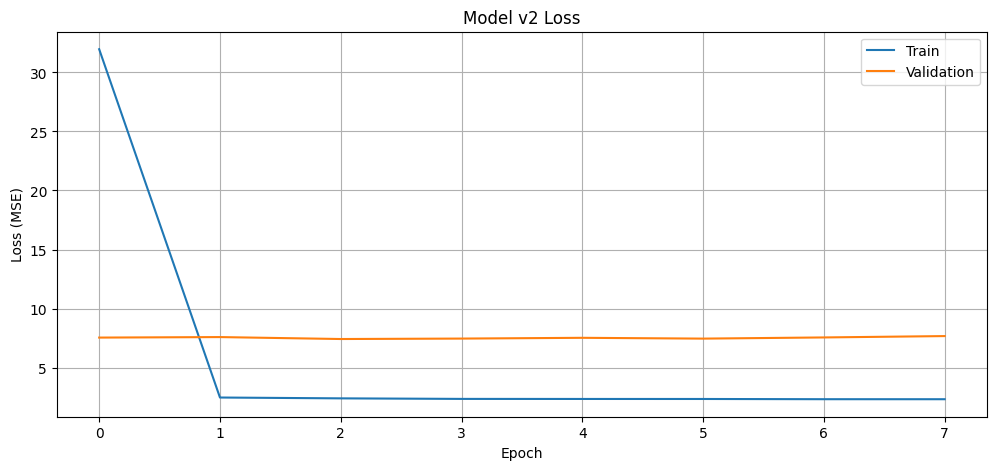

Test Set Mean Squared Error (v2): 5.6464
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


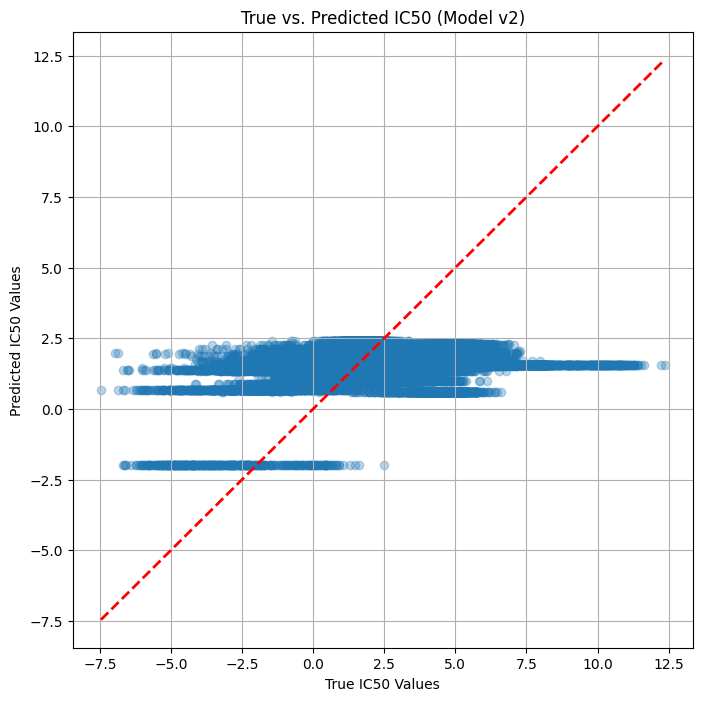

In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(12, 5))
plt.plot(history_v2.history['loss'])
plt.plot(history_v2.history['val_loss'])
plt.title('Model v2 Loss')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.grid(True)
plt.show()

# Evaluate the model on the test set
test_loss_v2 = model_v2.evaluate([X_test_genes, X_test_fp], y_test, verbose=0)
print(f"Test Set Mean Squared Error (v2): {test_loss_v2:.4f}")

# Make predictions on the test set
y_pred_v2 = model_v2.predict([X_test_genes, X_test_fp]).flatten()

# Plot true vs. predicted values
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_v2, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('True IC50 Values')
plt.ylabel('Predicted IC50 Values')
plt.title('True vs. Predicted IC50 (Model v2)')
plt.grid(True)
plt.show()

## Model 2 Results

After training Model 2 with reduced complexity and increased regularization, the test set MSE is Approximately 5.6m which is higher than Model 1's MSE of 4.67. In the true vs. predicted plot, this was similar to Model 1. The predictions show dispersion around the ideal line, and there's still a tendency to cluster predictions around certain values.

Despite the changes aimed at reducing overfitting, Model 2 did not outperform Model 1 on the test set based on the MSE. The early stopping helped manage the training process, but the simpler architecture and increased dropout might have limited the model's capacity to capture the underlying patterns in the data as effectively as Model 1.

## Model 3

For the third model, we'll employ [Keras Tuner](https://keras.io/keras_tuner/) to automatically sweep through a range of hyperparameters and return the best model for validation loss.

The hyperparameters we are modulating include the number of neural network units, the dropout rates, and the learning rates.

In [ ]:
!pip install keras-tuner

In [53]:
import keras_tuner as kt

def build_model(hp):
    # Gene Expression Branch
    gene_input = Input(shape=(X_train_genes.shape[1],), name='gene_input')
    gene_branch = Dense(units=hp.Int('gene_dense_1_units', min_value=64, max_value=512, step=32), activation='relu')(gene_input)
    gene_branch = Dropout(hp.Float('gene_dropout_1', min_value=0.1, max_value=0.5, step=0.1))(gene_branch)
    gene_branch = Dense(units=hp.Int('gene_dense_2_units', min_value=32, max_value=256, step=32), activation='relu')(gene_branch)

    # Drug Fingerprint Branch
    fp_input = Input(shape=(X_train_fp.shape[1],), name='fp_input')
    fp_branch = Dense(units=hp.Int('fp_dense_1_units', min_value=32, max_value=256, step=32), activation='relu')(fp_input)
    fp_branch = Dropout(hp.Float('fp_dropout_1', min_value=0.1, max_value=0.5, step=0.1))(fp_branch)
    fp_branch = Dense(units=hp.Int('fp_dense_2_units', min_value=16, max_value=128, step=16), activation='relu')(fp_branch)

    # Merge Branches
    merged = Concatenate()([gene_branch, fp_branch])
    merged = Dense(units=hp.Int('merged_dense_1_units', min_value=64, max_value=512, step=32), activation='relu')(merged)
    merged = Dropout(hp.Float('merged_dropout_1', min_value=0.1, max_value=0.5, step=0.1))(merged)
    merged = Dense(units=hp.Int('merged_dense_2_units', min_value=32, max_value=256, step=32), activation='relu')(merged)


    # Output Layer
    output = Dense(1, activation='linear', name='output')(merged)

    model = Model(inputs=[gene_input, fp_input], outputs=output)

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                  loss='mean_squared_error')

    return model

In [54]:
# Instantiate the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,  # Number of hyperparameter combinations to try
    executions_per_trial=2,  # Number of models to train per combination
    directory='keras_tuner_dir', # Directory to save results
    project_name='drug_efficacy_tuning'
)

# Define Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Run the hyperparameter search
tuner.search(
    [X_train_genes, X_train_fp],
    y_train,
    epochs=50, # Maximum number of epochs to train each model
    validation_split=0.2,
    callbacks=[early_stopping]
)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("\nOptimal Hyperparameters found:")
print(f"Gene Dense 1 Units: {best_hps.get('gene_dense_1_units')}")
print(f"Gene Dropout 1: {best_hps.get('gene_dropout_1')}")
print(f"Gene Dense 2 Units: {best_hps.get('gene_dense_2_units')}")
print(f"FP Dense 1 Units: {best_hps.get('fp_dense_1_units')}")
print(f"FP Dropout 1: {best_hps.get('fp_dropout_1')}")
print(f"FP Dense 2 Units: {best_hps.get('fp_dense_2_units')}")
print(f"Merged Dense 1 Units: {best_hps.get('merged_dense_1_units')}")
print(f"Merged Dropout 1: {best_hps.get('merged_dropout_1')}")
print(f"Merged Dense 2 Units: {best_hps.get('merged_dense_2_units')}")
print(f"Learning Rate: {best_hps.get('learning_rate')}")

Trial 10 Complete [00h 05m 57s]
val_loss: 6.522628545761108

Best val_loss So Far: 6.096991539001465
Total elapsed time: 00h 59m 07s

Optimal Hyperparameters found:
Gene Dense 1 Units: 64
Gene Dropout 1: 0.2
Gene Dense 2 Units: 64
FP Dense 1 Units: 96
FP Dropout 1: 0.5
FP Dense 2 Units: 96
Merged Dense 1 Units: 96
Merged Dropout 1: 0.1
Merged Dense 2 Units: 224
Learning Rate: 0.001



Test Set Mean Squared Error (Tuned Model): 4.9768
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


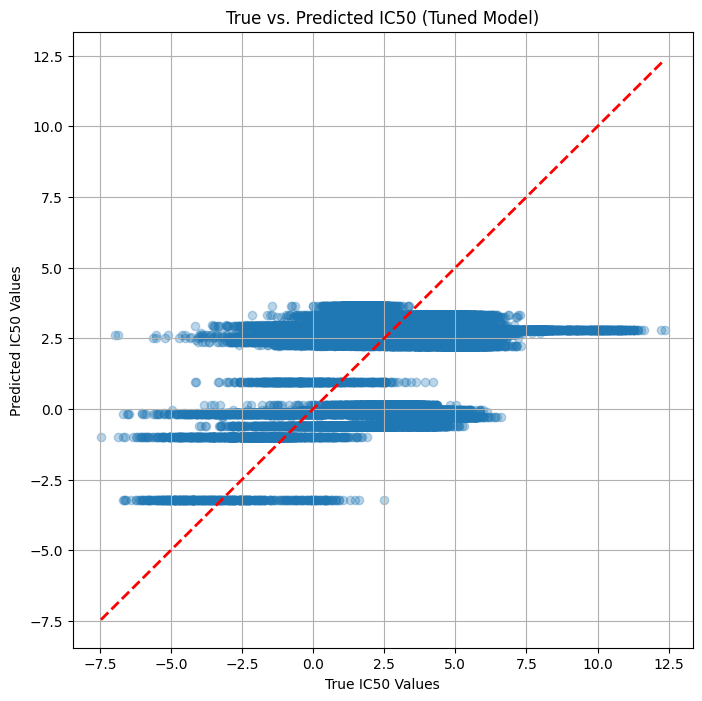

In [55]:
# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model on the test set
test_loss_tuned = best_model.evaluate([X_test_genes, X_test_fp], y_test, verbose=0)
print(f"\nTest Set Mean Squared Error (Tuned Model): {test_loss_tuned:.4f}")

# Make predictions on the test set with the best model
y_pred_tuned = best_model.predict([X_test_genes, X_test_fp]).flatten()

# Plot true vs. predicted values for the tuned model
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_tuned, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('True IC50 Values')
plt.ylabel('Predicted IC50 Values')
plt.title('True vs. Predicted IC50 (Tuned Model)')
plt.grid(True)
plt.show()

## Model 3 Results

The hyperparameter tuning didn't produce markedly different results than the earlier models, and was even slightly worse than the first model. The true-vs-predicted plot shows no improvement with the predicted values still bunching in single-valued bands. This suggests that we need to further investigate other architectural changes like batch normalization or other normalization techniques.

## Model 4

As a last attempt, we'll define a model based on the Model 1 choice of hyperparameters, but with the addition of batch normalization layers after each dense layer.

In [56]:
# Model 4 with Batch Normalization

# Gene Expression Branch
gene_input_bn = Input(shape=(X_train_genes.shape[1],), name='gene_input_bn')
gene_branch_bn = Dense(256, activation='relu')(gene_input_bn)
gene_branch_bn = tf.keras.layers.BatchNormalization()(gene_branch_bn)
gene_branch_bn = Dropout(0.3)(gene_branch_bn)
gene_branch_bn = Dense(128, activation='relu')(gene_branch_bn)
gene_branch_bn = tf.keras.layers.BatchNormalization()(gene_branch_bn)


# Drug Fingerprint Branch
fp_input_bn = Input(shape=(X_train_fp.shape[1],), name='fp_input_bn')
fp_branch_bn = Dense(128, activation='relu')(fp_input_bn)
fp_branch_bn = tf.keras.layers.BatchNormalization()(fp_branch_bn)
fp_branch_bn = Dropout(0.3)(fp_branch_bn)
fp_branch_bn = Dense(64, activation='relu')(fp_branch_bn)
fp_branch_bn = tf.keras.layers.BatchNormalization()(fp_branch_bn)


# Merge Branches
merged_bn = Concatenate()([gene_branch_bn, fp_branch_bn])
merged_bn = Dense(256, activation='relu')(merged_bn)
merged_bn = tf.keras.layers.BatchNormalization()(merged_bn)
merged_bn = Dropout(0.4)(merged_bn)
merged_bn = Dense(128, activation='relu')(merged_bn)
merged_bn = tf.keras.layers.BatchNormalization()(merged_bn)


# Output Layer
output_bn = Dense(1, activation='linear', name='output_bn')(merged_bn)

# Create and Compile Model
model_bn = Model(inputs=[gene_input_bn, fp_input_bn], outputs=output_bn)
model_bn.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

model_bn.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ gene_input_bn       │ (None, 13391)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fp_input_bn         │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 256)       │  3,428,352 │ gene_input_bn[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 128)       │    262,272 │ fp_input_bn[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256)       │      1,024 │ dense_6[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_8[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 128)       │     32,896 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 64)        │      8,256 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_7[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_9[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 192)       │          0 │ batch_normalizat… │
│ (Concatenate)       │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 256)       │     49,408 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_10[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 128)       │     32,896 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_11[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_bn (Dense)   │ (None, 1)         │        129 │ batch_normalizat… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,818,049 (14.56 MB)

 Trainable params: 3,816,129 (14.56 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [57]:
# Define Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with Batch Normalization
history_bn = model_bn.fit(
    [X_train_genes, X_train_fp],
    y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=128,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
865/865 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - loss: 3.6326 - val_loss: 7.4146
Epoch 2/50
865/865 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 1.7394 - val_loss: 7.7441
Epoch 3/50
865/865 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 1.5761 - val_loss: 7.4918
Epoch 4/50
865/865 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 1.5015 - val_loss: 7.4696
Epoch 5/50
865/865 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 1.4648 - val_loss: 7.6893
Epoch 6/50
865/865 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 1.4254 - val_loss: 7.9803


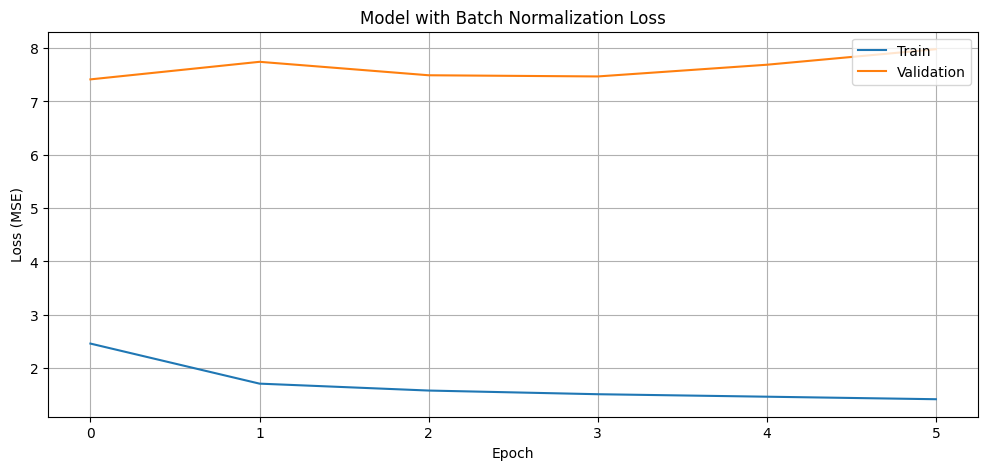

Test Set Mean Squared Error (Model with Batch Normalization): 4.2848
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


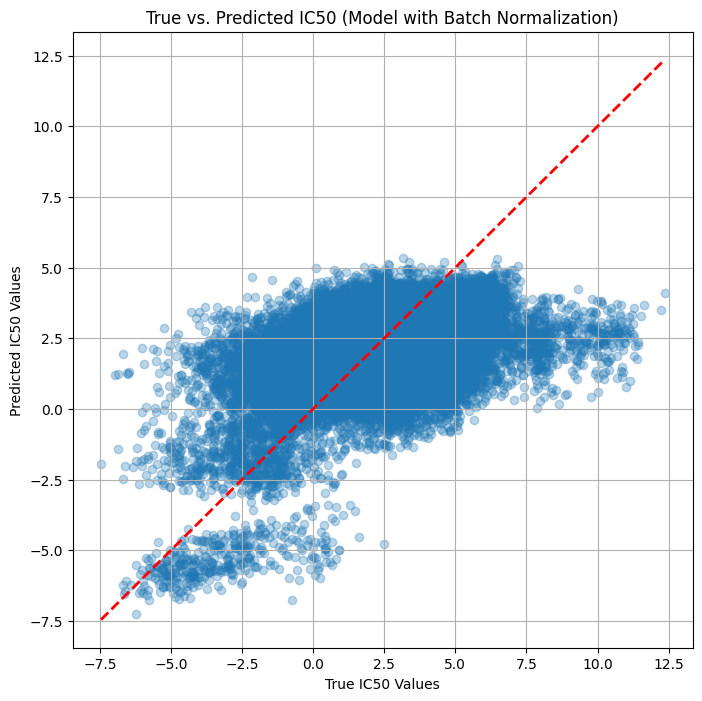

In [58]:
# Plot training & validation loss values
plt.figure(figsize=(12, 5))
plt.plot(history_bn.history['loss'])
plt.plot(history_bn.history['val_loss'])
plt.title('Model with Batch Normalization Loss')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.grid(True)
plt.show()

# Evaluate the model on the test set
test_loss_bn = model_bn.evaluate([X_test_genes, X_test_fp], y_test, verbose=0)
print(f"Test Set Mean Squared Error (Model with Batch Normalization): {test_loss_bn:.4f}")

# Make predictions on the test set
y_pred_bn = model_bn.predict([X_test_genes, X_test_fp]).flatten()

# Plot true vs. predicted values
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_bn, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('True IC50 Values')
plt.ylabel('Predicted IC50 Values')
plt.title('True vs. Predicted IC50 (Model with Batch Normalization)')
plt.grid(True)
plt.show()

## Model 4 Results

This model with Batch Normalization achieved an MSE of ~4.2848 on the test set, which was the best so far. The scatter plot of true versus predicted IC50 values shows a general positive correlation but still shows significant dispersion around the ideal prediction line. At least the batch normalization seems to be correcting the earlier models' tendency to output only select IC 50 values.

## Conclusion

This project aimed to build a deep learning model to predict drug efficacy based on cancer cell gene expression and drug molecular structure. I explored several model architectures, including a multi-input neural network, a tuned version using KerasTuner, and a model incorporating batch normalization.

While the models showed some ability to predict log(IC50) values, as indicated by the positive correlation in the true vs. predicted plots, the MSE values suggest there is significant room for improvement. The clustering of predictions around certain values was a persistent issue across models except the last model, where batch normalization seems to provide some improvement. More tuning and experimentation would be necessary to discover further improvements.

Despite not achieving high predictive accuracy from these models, I learned a great deal about working with bioinformatics data, and I now have a glimplse into building and evaluating deep learning models for regression tasks.

I'm still deeply interested in this topic and plan to continue exploring it in the future. Potential future steps include investigating different model architectures (graph neural networks, etc.), trying other machine learning algorithms suited tabular data, and potentially incorporating additional biological and chemical features from the GDSC dataset.